# Plant Pathology

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

## Read data

In [2]:
# train
train = pd.read_csv('../Data/train.csv')
train['image_id'] = train['image_id'].apply(lambda x: x + '.jpg')
#test
test = pd.read_csv('../Data/test.csv')
test['image_id'] = test['image_id'].apply(lambda x: x + '.jpg')

In [3]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [4]:
test.head()

,image_id
0,Test_0.jpg
1,Test_1.jpg
2,Test_2.jpg
3,Test_3.jpg
4,Test_4.jpg


## Image processing

### Load image

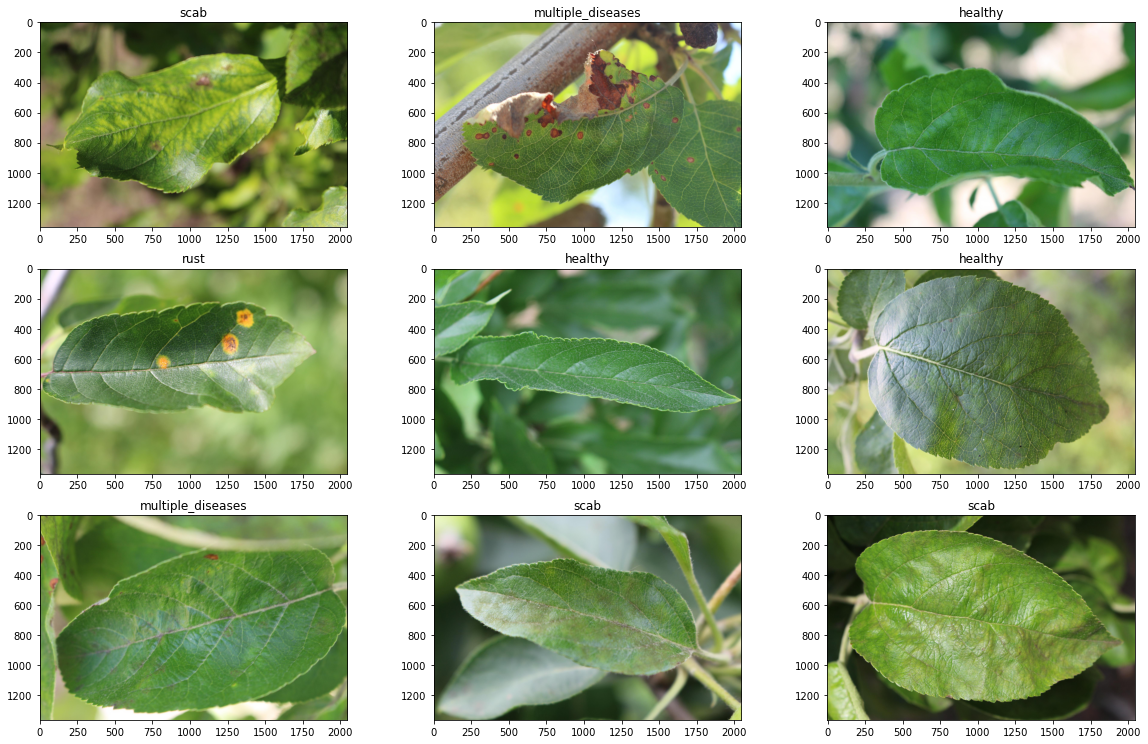

In [5]:
i = 1
plt.figure(figsize=(20,40))
for idx, s in train.head(9).iterrows():
    path = '../Data/images/'
    path = path + s['image_id']
    title = [x for x in [key if val == 1 else '' for key, val in s.items()] if x][0]
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig=plt.subplot(9,3,i)
    fig.imshow(img)
    fig.set_title(title)
    i+=1

#### Nhận xét:
- scab: Lá bị nhăn vàng nhạt.
- rust: Có những đóm vàng trên lá.
- multiple_diseases: Lá bị vàng, có những đóm đỏ vàng.
- healthy: lá xanh, mướt.

<BarContainer object of 4 artists>

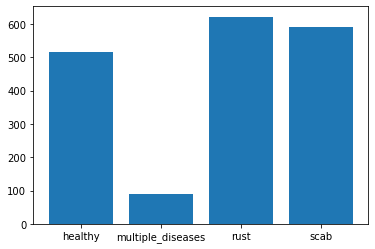

In [6]:
plt.bar(x = train.columns[1:], height = train.sum(axis = 0)[1:])

### Using tensorflow generate data from dataframe

In [7]:
batch_size = 32  
img_height = 256 # height of image
img_width = 256  # width of image
img_path = '../Data/images/'

### train_datagen

### Vấn đề của bài toán: Dữ liệu ảnh ít
### Khắc phục:  Sử dụng class ImageDataGenerator trong keras để tăng cường ảnh.
* Đầu tiên tạo một datagen với các tham số điều chỉnh: 
    - `rescale` : Hệ số thay đổi tỉ lệ.
    - `zoom_range` : Zoom ảnh trong khoảng cho trước.
    - `rotation_range` : Quay ảnh với số cho cho trước.
    - `brightness_range` : Tăng độ sáng ngẫu nhiên trong khoảng cho trước.
    - `horizontal_flip` : Lật ngẫu nhiên theo chiều ngang.
    - `vertical_flip` : Lật ngẫu nhiên theo chiều dọc.
    - `validation_split` : Kích thước tập validation.
    

* Tiếp theo sẽ tạo tập train và tập validation từ datagen vừa tạo: sử dụng `flow_from_dataframe` để đọc ảnh với filename lấy từ dataframe.
    - `dataframe` : Tên dataframe chứa filename.
    - `directory` : Đường dẫn đến thư mục chứa ảnh.
    - `x_col` : Tên thuộc tính trong dataframe chứa filename.
    - `y_col` : Tên các giá trị phân lớp ảnh.
    - `target_size` : Size ảnh, các ảnh sẽ được rescale theo kích thước này.
    - `class_mode` : Chế độ đọc phân lớp ảnh. Nếu là phân lớp 2 ảnh thì set là binary, nhiều lớp thì categorical, trong trường hợp này `class_mode` được chọn là `raw` với các giá trị là mảng numpy lấy từ y_col.
    - `batch_size` : Kích thước mỗi ô dữ liệu.
    -  `subset` : "training" hoặc "validation", nếu ở class ImageDataGenerator có sử dụng `validation_split`.
    - `shuffle` : Xáo trộn dữ liệu.
    - `validate_filenames` : Xác thực hình ảnh.

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,                  
    zoom_range=(1, 1.3),             
    rotation_range = 180,            
    brightness_range = (0.7, 1.3),
    horizontal_flip=True,            
    vertical_flip=True,              
    validation_split = 0.2           
)

labels = ["healthy","multiple_diseases","rust","scab"]

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory = img_path,
    x_col = "image_id",
    y_col= labels,
    target_size = (img_height,img_width),
    class_mode="raw",
    batch_size = batch_size,
    subset = "training",
    shuffle = True,
    validate_filenames = False
)
val_generator = train_datagen.flow_from_dataframe(
    train,
    directory = img_path,
    x_col = "image_id",
    y_col= labels,
    target_size = (img_height,img_width),
    class_mode="raw",
    batch_size = batch_size,
    subset = "validation",
    shuffle = True,
    validate_filenames = False
)

Found 1457 non-validated image filenames.
Found 364 non-validated image filenames.


### test_datagen : Tương tự như tập train nhưng có một vài điều chỉnh như sau:
* Ở class `ImageDataGenerator` không truyền các tham số thay đổi ảnh. Thưc chất quá trình này là đọc ảnh từ thư mục test.
* Ở flow_from_dataframe: thay tên `dataframe` là train thành test.
    - `class_mode`: None 
    - `shuffle` : False

In [9]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory = img_path,
    x_col = 'image_id',
    target_size = (img_height,img_width),
    class_mode= None,
    batch_size = 1,
    shuffle = False,
    validate_filenames = False
)

Found 1821 non-validated image filenames.


# Make Neural network using Sequential

### Xây dựng mạng CNN từ model `Sequential` của keras:
##### Model `Sequential` là một stack các lớp tuyến tính với nhau, mỗi lớp có mỗi trọng số tương ứng với lớp theo sau nó. Có thể sử dụng hàm `add()` để thêm các layers vào model. Các layer được sử dụng:
* `Conv2D` : Tạo một Convolution kernel convolved layer input để tạo ra tensor outputs. Với hàm kích hoạt `activation` khác `None`, và cần phải đặt `input_shape` cho <font color=red> layer đầu tiên.</font>
* `MaxPooling2D` : Thường được xây dựng ở giữa hai Convolutional layer. Dùng để lấy các feature nổi bật, giảm kích thước dữ liệu giúp giảm chi phí tính toán.
* `Flatten` : Chuyển từ tensor sang vector
* `Dense` : Khai báo số lượng đầu ra và hàm kích hoạt của nó.

In [10]:
# 5. Định nghĩa model
model = Sequential()
# Xây dựng model:

### Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
### dùng hàm relu làm activation và chỉ rõ input_shape cho layer đầu tiên
model.add(Conv2D(32, (3, 3), activation='relu',input_shape = (img_height,img_width,3), padding = 'same'))
### Thêm MaxPooling2D với pooling size = (4,4)
model.add(MaxPooling2D(4,4))
### Thêm 1 Convolutional mới với 64 kernel, kích thước 3*3 với activation là relu.
model.add(Conv2D(64,(3,3), activation='relu',padding='same'))
### Thêm MaxPooling2D với pooling size = (4,4)
model.add(MaxPooling2D(4,4))
### Thêm 1 Convolutional mới với 128 kernel, kích thước 3*3 với activation là relu.
model.add(Conv2D(128,(3,3), activation='relu',padding='same'))
### Thêm MaxPooling2D với pooling size = (4,4)
model.add(MaxPooling2D(4,4))

### Chuyển từ tensor sang vector
model.add(Flatten())
### Output layer với 4 node (4 loại bệnh của cây) và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(4,activation='softmax'))

# Compile model
'''
    + Hàm loss: categorical_crossentropy
    + Phương thức tối ưu hàm loss: adam
    + Đánh giá: accuraty: Số lượng điểm được phân loại đúng trong toàn bộ số điểm.
'''
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [11]:
model.build((None,img_height,img_width,3))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 256, 256, 32)      896       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 64, 64, 32)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 64, 64, 64)        18496     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 16, 16, 64)        0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 16, 16, 128)       73856     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 4, 4, 128)         0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 2048)              0

In [13]:
model_history=model.fit(train_generator,validation_data=val_generator,
                             epochs=100,
                             steps_per_epoch=train_generator.samples//batch_size,
                             validation_steps=val_generator.samples//batch_size)

Epoch 1/100
45/45 [==============================] - 106s 2s/step - loss: 1.2491 - accuracy: 0.3677 - val_loss: 1.2467 - val_accuracy: 0.2472
Epoch 2/100
45/45 [==============================] - 103s 2s/step - loss: 1.2337 - accuracy: 0.3389 - val_loss: 1.2315 - val_accuracy: 0.3892
Epoch 3/100
45/45 [==============================] - 102s 2s/step - loss: 1.2213 - accuracy: 0.3796 - val_loss: 1.2911 - val_accuracy: 0.3523
Epoch 4/100
45/45 [==============================] - 102s 2s/step - loss: 1.2118 - accuracy: 0.4084 - val_loss: 1.2090 - val_accuracy: 0.5256
Epoch 5/100
45/45 [==============================] - 102s 2s/step - loss: 1.1502 - accuracy: 0.4849 - val_loss: 1.0764 - val_accuracy: 0.6108
Epoch 6/100
45/45 [==============================] - 108s 2s/step - loss: 0.9289 - accuracy: 0.6589 - val_loss: 0.8444 - val_accuracy: 0.6591
Epoch 7/100
45/45 [==============================] - 102s 2s/step - loss: 0.6875 - accuracy: 0.7284 - val_loss: 0.6763 - val_accuracy: 0.7642
Epoch 

#### Visualization

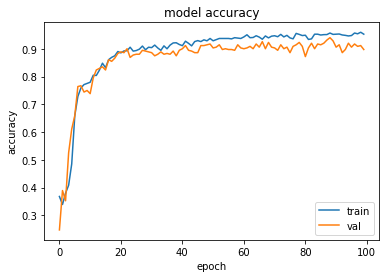

In [15]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

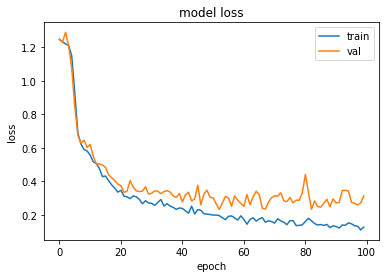

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

### Kết quả trên tập test.

In [20]:
prob = model.predict(test_generator)

In [18]:
submis = pd.read_csv('../Data/sample_submission.csv')

In [21]:
submis.loc[:,'healthy':] = prob

In [22]:
submis.to_csv('../Data/new_submission.csv',index=False)

In [23]:
pd.read_csv('../Data/new_submission.csv')

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.713974e-19,0.000105,0.999895,3.134841e-19
1,Test_1,5.493668e-10,0.004522,0.995478,5.359919e-11
2,Test_2,1.841169e-02,0.031095,0.000537,9.499565e-01
3,Test_3,9.992368e-01,0.000071,0.000160,5.317639e-04
4,Test_4,6.161816e-35,0.000164,0.999835,7.048558e-30
...,...,...,...,...,...
1816,Test_1816,1.817488e-12,0.018827,0.981173,1.194866e-15
1817,Test_1817,1.124417e-06,0.008312,0.000184,9.915032e-01
1818,Test_1818,1.904860e-16,0.000095,0.999905,7.519307e-17
1819,Test_1819,9.984851e-01,0.000043,0.000457,1.015040e-03


# Reference
`https://topdev.vn/blog/thuat-toan-cnn-convolutional-neural-network/`

`https://www.tensorflow.org/api_docs/python/tf/keras/Sequential`

`https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models`